# https://www.kaggle.com/darkside92/detailed-examination-for-house-price-top-10

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import seaborn as sns  
import warnings
warnings.filterwarnings("ignore")         # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
np.set_printoptions(np.inf)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics
plt.rcParams['figure.figsize'] = (10, 8)
# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
np.set_printoptions(threshold=np.inf)
import xgboost as xgb
import lightgbm as lgb
import time
import pickle
import gc

In [2]:
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

In [3]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')
sample_sub = pd.read_csv('../house price/sample_submission.csv')

# １.前処理

In [4]:
correlation_train=train.corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
# ax = sb.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

<Figure size 3600x2520 with 0 Axes>

<Figure size 3600x2520 with 0 Axes>

## 相関係数の高い特徴量を抜き出す

In [5]:
corr_dict = correlation_train['SalePrice'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_columns.append(key)
important_columns

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'LotFrontage',
 'WoodDeckSF',
 '2ndFlrSF',
 'OpenPorchSF',
 'HalfBath',
 'LotArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'ScreenPorch',
 'EnclosedPorch',
 'KitchenAbvGr']

## 欠損値の補完と簡単な特徴量エンジニアリング

In [7]:
train_test=pd.concat([train,test],axis=0,sort=False)
train_test.loc[train_test['Fireplaces']==0,'FireplaceQu']='Nothing'
train_test['LotFrontage'] = train_test['LotFrontage'].fillna(train_test.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
train_test['LotFrontage'].interpolate(method='linear',inplace=True)
train_test['LotFrontage']=train_test['LotFrontage'].astype(int)
train_test['MasVnrArea'] = train_test['MasVnrArea'].fillna(train_test.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
train_test['MasVnrArea'].interpolate(method='linear',inplace=True)
train_test['MasVnrArea']=train_test['MasVnrArea'].astype(int)
train_test["Fence"] = train_test["Fence"].fillna("None")
train_test["FireplaceQu"] = train_test["FireplaceQu"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["MiscFeature"] = train_test["MiscFeature"].fillna("None")
train_test.loc[train_test['BsmtFinSF1']==0,'BsmtFinType1']='Unf'
train_test.loc[train_test['BsmtFinSF2']==0,'BsmtQual']='TA'
train_test['YrBltRmd']=train_test['YearBuilt']+train_test['YearRemodAdd']
train_test['Total_Square_Feet'] = (train_test['BsmtFinSF1'] + train_test['BsmtFinSF2'] + train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF'])
train_test['Total_Bath'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) + train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))
train_test['Total_Porch_Area'] = (train_test['OpenPorchSF'] + train_test['3SsnPorch'] + train_test['EnclosedPorch'] + train_test['ScreenPorch'] + train_test['WoodDeckSF'])
train_test['exists_pool'] = train_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_garage'] = train_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_fireplace'] = train_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_bsmt'] = train_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['old_house'] = train_test['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1
                    , "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1
                    , "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2
                    , "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2
                    , "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3
                    , "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4
                    , "NridgHt" : 4}

train_test['NeighborhoodBin'] = train_test['Neighborhood'].map(neighborhood_map)
for i in train_test.columns:
    if 'SalePrice' not in i:
        if 'object' in str(train_test[str(i)].dtype):
            train_test[str(i)]=train_test[str(i)].fillna(method='ffill')

train_test["VeryNewHouse"] = (train_test["YearBuilt"] == train_test["YrSold"]) * 1
train_test["Age"] = 2010 - train_test["YearBuilt"]
train_test['binned_Age'] = pd.cut(train_test['Age'], 10,labels=False)
train_test["HighSeason"] = train_test["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 
                                                   7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
train_test["SaleCondition_PriceDown"] = train_test.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})
train_test["BoughtOffPlan"] = train_test.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
train_test["BadHeating"] = train_test.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
train_test_or = train_test[(train_test['BadHeating'] == 1) | (train_test['CentralAir'] == 'N')]
train_test_or['BadAir'] = 0
train_test = train_test.merge(train_test_or[['Id', 'BadAir']], on='Id', how='left')
train_test['BadAir'] = train_test['BadAir'].fillna(1).astype(np.int8)
del train_test_or
gc.collect()

0

## one-hotエンコーディングと正規化

In [8]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(train_test[col].values)) 
    train_test[col] = lbl_enc.transform(list(train_test[col].values))

In [9]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index
skewed_features = train_test[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index
for feature in skewed_features:
    train_test[feature] = boxcox1p(train_test[feature], boxcox_normmax(train_test[feature] + 1))

In [10]:
train_test=pd.get_dummies(train_test, dtype='int8')

In [11]:
train=train_test[0:1460]
test=train_test[1460:2919]

In [12]:
train = train.interpolate(method='linear')
test = test.interpolate(method='linear')
#線形に欠損値を補完

## 特徴量選択の準備

In [13]:
corr_new_train=train.corr()
corr_dict2=corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
best_columns=[]
for key,value in corr_dict2.items():
    if ((value>=0.3175) & (value<0.9)) | (value<=-0.315):
        best_columns.append(key)

## 目的変数の対数変換とクラスタリング、可視化に基づく外れ値除去

In [14]:
train['SalePrice_Log1p'] = np.log1p(train.SalePrice)
train.drop([197,810,1170,1182,1298,1386,1423], axis=0, inplace=True)

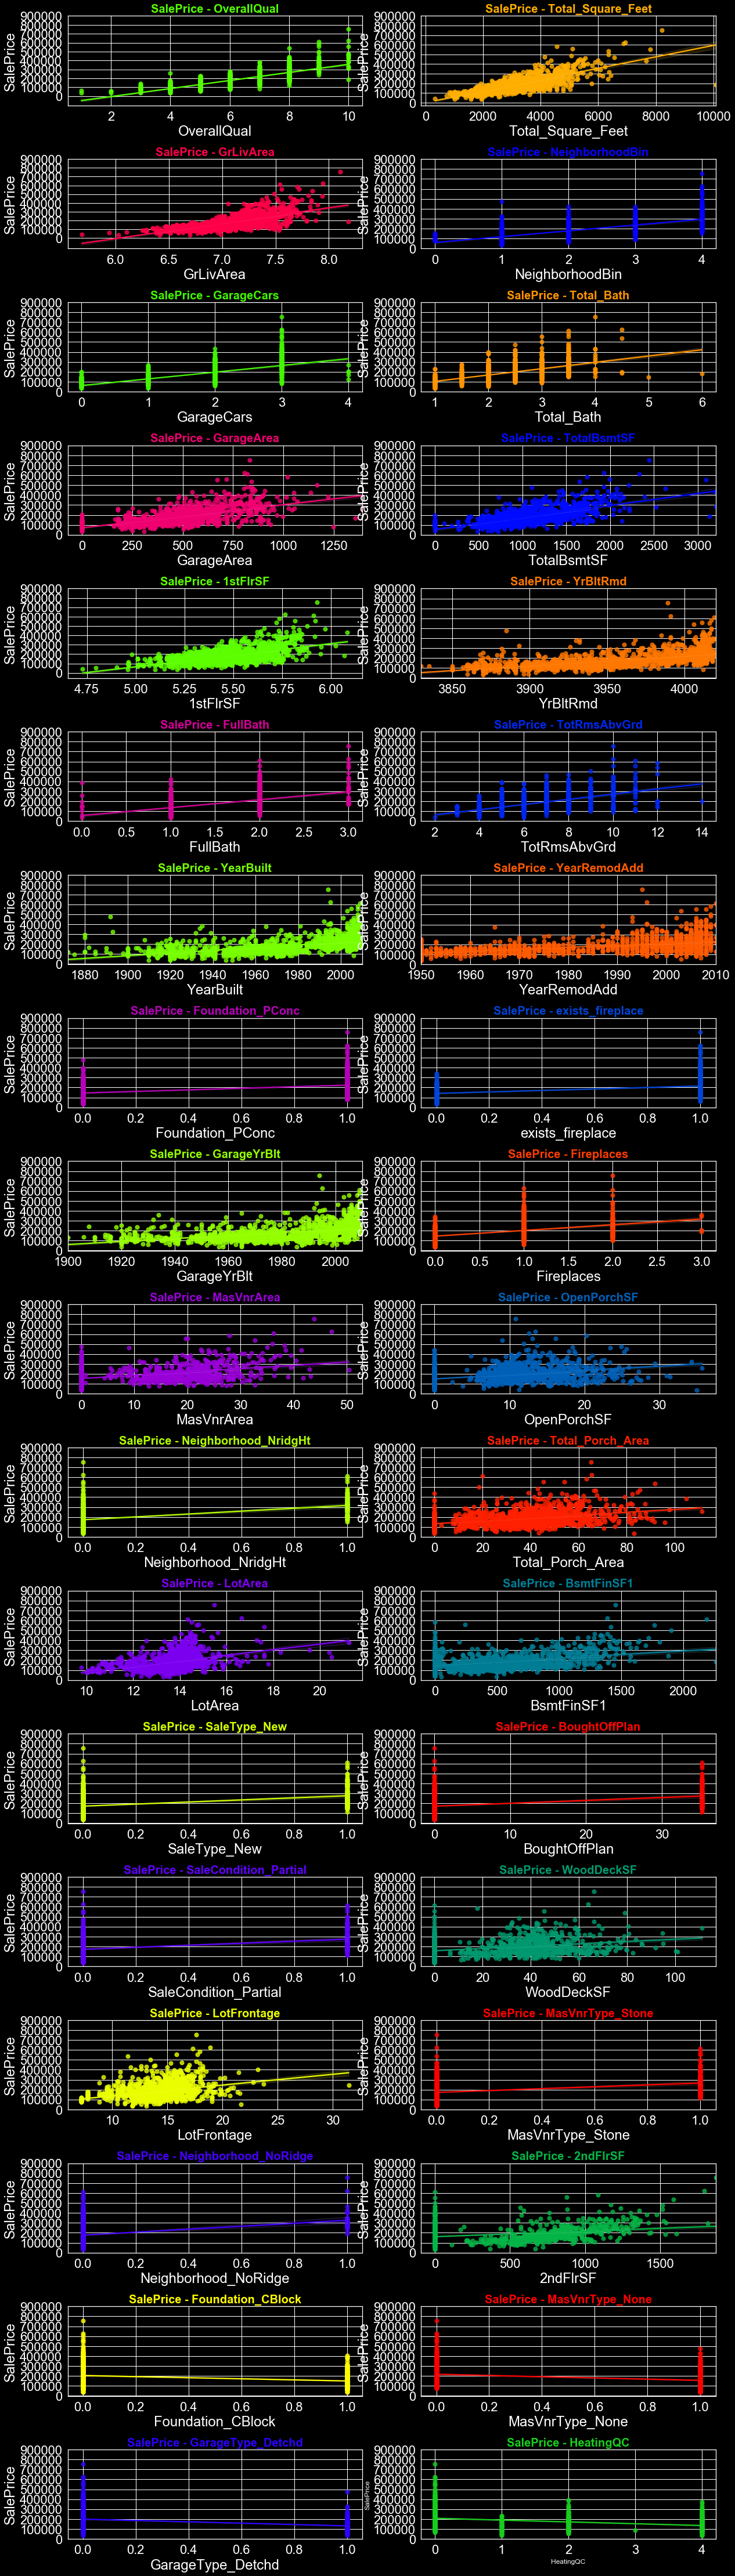

In [15]:
plt.style.use('dark_background')
fig, axes = plt.subplots(18, 2,figsize=(20,80))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.8},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('SalePrice'+' - '+str(i),color=color,fontweight='bold',size=20)

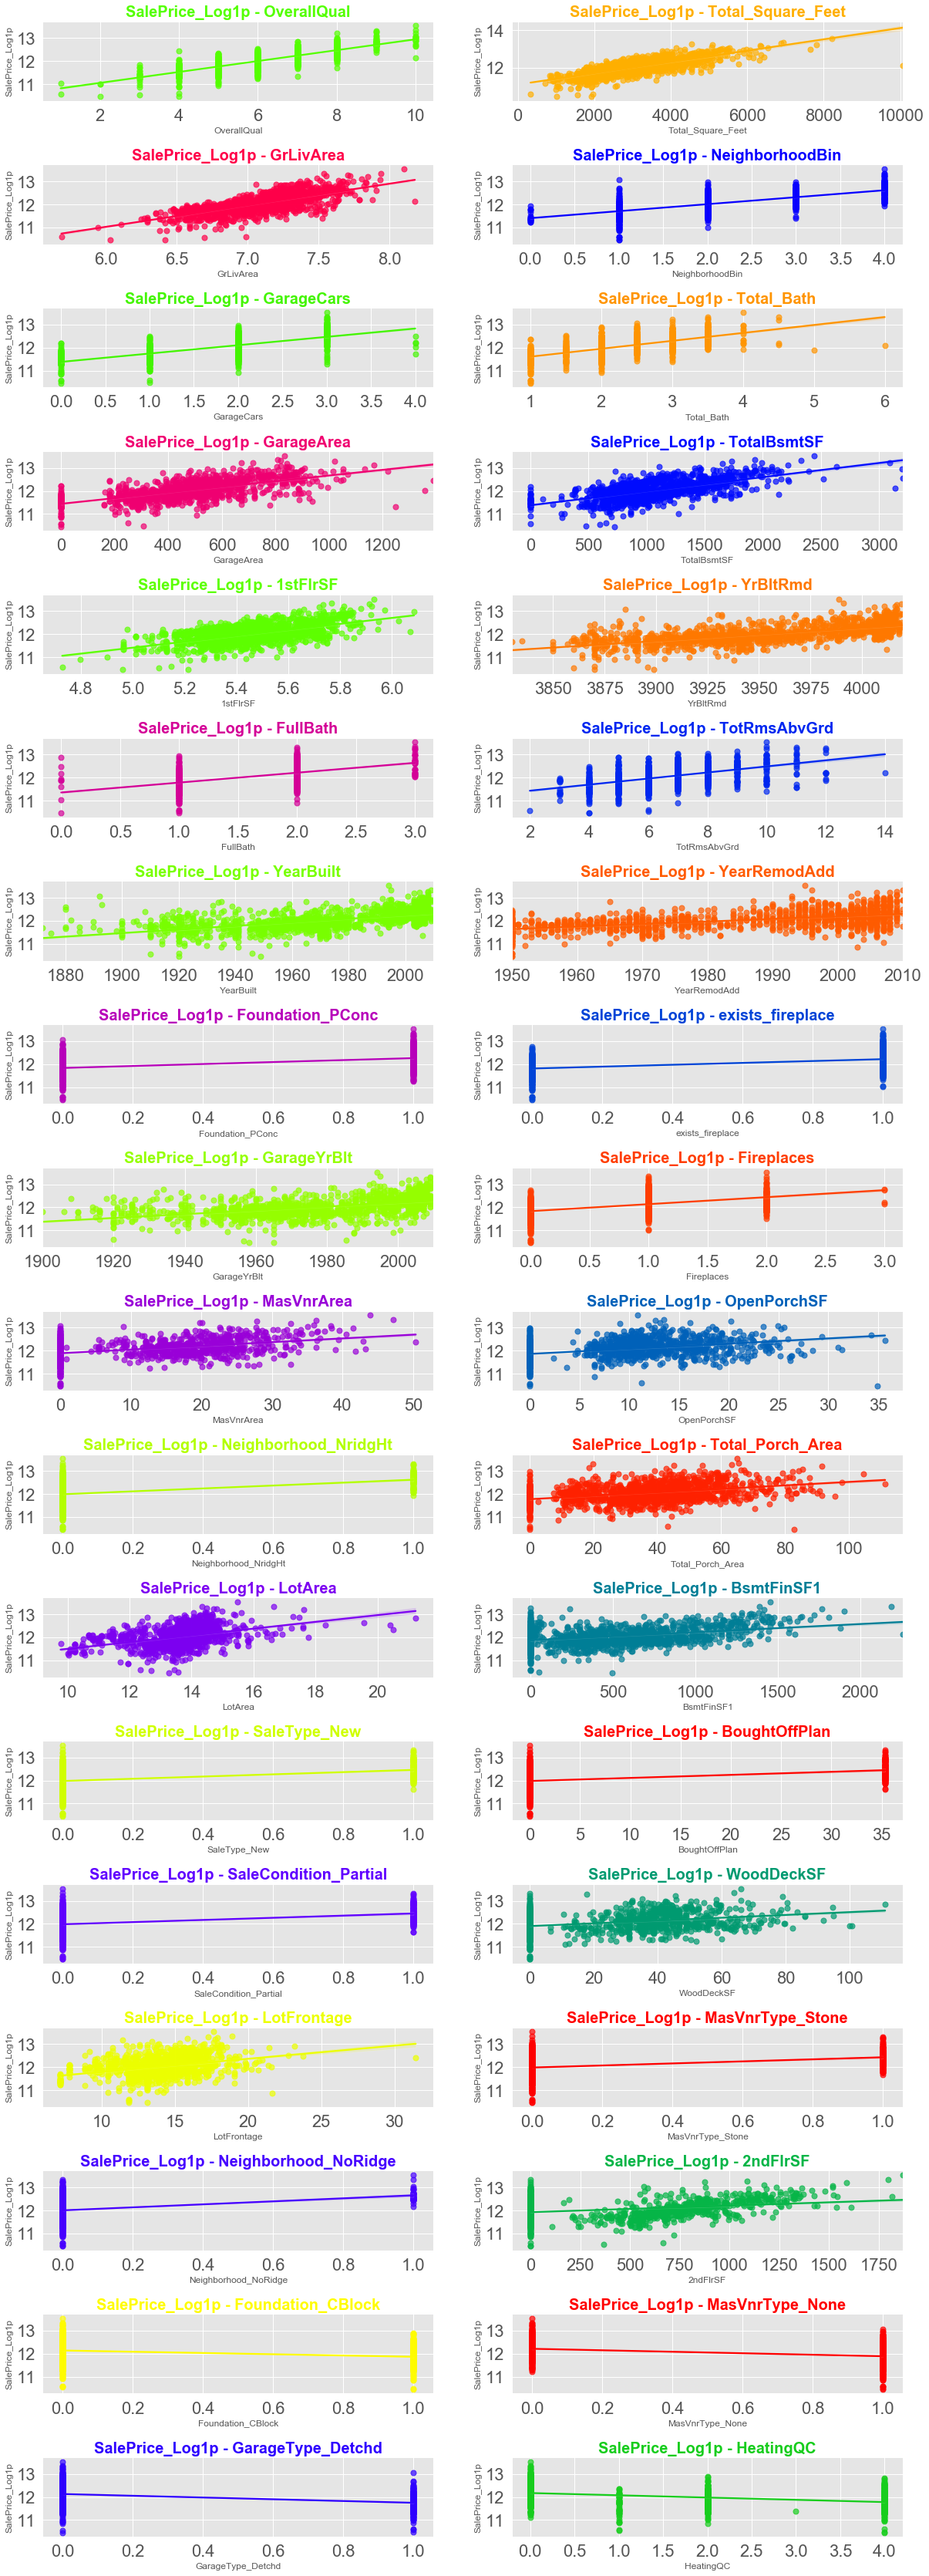

In [16]:
#対数とった方
plt.style.use('ggplot')
fig, axes = plt.subplots(18, 2,figsize=(20,60))
fig.subplots_adjust(hspace=0.8)
sb.set(font_scale=1.2)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice_Log1p"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.7},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice_Log1p',fontsize=12)
    ax.set_title('SalePrice_Log1p'+' - '+str(i),color=color,fontweight='bold',size=20)

In [17]:
train = train.drop(train[(train.OverallQual==4) & (train.SalePrice>200000)].index)
train = train.drop(train[(train.OverallQual==10) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.Total_Square_Feet>=10000) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.Total_Square_Feet<3000) & (train.SalePrice>375000)].index)
train = train.drop(train[(train.GrLivArea>4500) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.GrLivArea<3000) & (train.SalePrice>575000)].index)
train = train.drop(train[(train.GarageArea>1200) & (train.SalePrice<165000)].index)
train = train.drop(train[(train.Total_Bath.isin([5,6])) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.TotRmsAbvGrd==10) & (train.SalePrice>700000)].index)
train = train.drop(train[(train.YearBuilt<1900) & (train.SalePrice>250000)].index)
train = train.drop(train[(train.YearBuilt>2000) & (train.SalePrice<100000)].index)
train = train.drop(train[(train.YearRemodAdd<1970) & (train.SalePrice>350000)].index)
train = train.drop(train[(train.MasVnrArea>=1400) & (train.SalePrice<250000)].index)
train = train.drop(train[(train.GarageYrBlt<1960) & (train.SalePrice>340000)].index)
train = train.drop(train[(train.Total_Porch_Area>600) & (train.SalePrice<50000)].index)
train = train.drop(train[(train.LotFrontage>150) & (train.SalePrice<100000)].index)
train = train.drop(train[(train.GarageFinish.isin([1,2])) & (train.SalePrice>470000)].index)
train = train.drop(train[(train.old_house==0) & (train.SalePrice<100000)].index)
train = train.drop(train[(train.old_house==1) & (train.SalePrice>400000)].index)
train = train.drop(train[(train.KitchenQual==2) & (train.SalePrice>600000)].index)
train = train.drop(train[(train.KitchenQual==3) & (train.SalePrice>360000)].index)
train = train.drop(train[(train.ExterQual==2) & (train.SalePrice>550000)].index)

train = train[train.GarageArea * train.GarageCars < 3700]
train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]

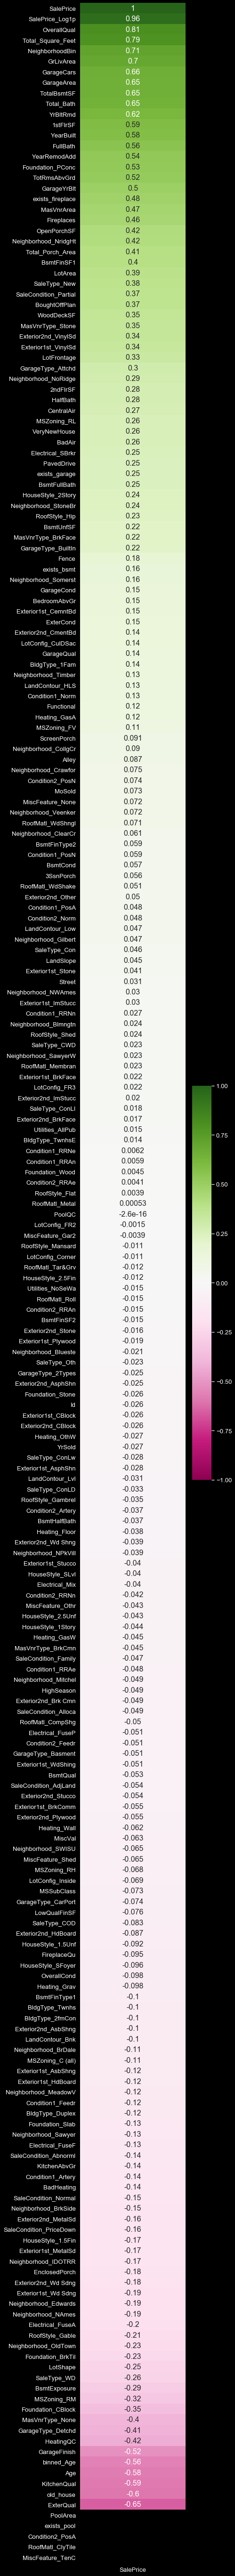

In [19]:
plt.style.use('dark_background')
corr1_new_train=train.corr()
plt.figure(figsize=(5,100))
sb.heatmap(corr1_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sb.set(font_scale=2)

In [20]:
corr_dict2=corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
best_columns=[]
for key,value in corr_dict2.items():
    if ((value>=0.25) & (value<0.9)) | (value<=-0.25):
        best_columns.append(key)

['OverallQual',
 'Total_Square_Feet',
 'GrLivArea',
 'NeighborhoodBin',
 'GarageCars',
 'Total_Bath',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YrBltRmd',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation_PConc',
 'exists_fireplace',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'OpenPorchSF',
 'Neighborhood_NridgHt',
 'Total_Porch_Area',
 'LotArea',
 'BsmtFinSF1',
 'SaleType_New',
 'BoughtOffPlan',
 'SaleCondition_Partial',
 'WoodDeckSF',
 'LotFrontage',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 '2ndFlrSF',
 'Exterior2nd_VinylSd',
 'Exterior1st_VinylSd',
 'HalfBath',
 'GarageType_Attchd',
 'CentralAir',
 'LotShape',
 'MSZoning_RM',
 'BsmtExposure',
 'Foundation_CBlock',
 'MasVnrType_None',
 'GarageType_Detchd',
 'HeatingQC',
 'GarageFinish',
 'binned_Age',
 'Age',
 'old_house',
 'KitchenQual',
 'ExterQual']

In [24]:
data = pd.concat([train, test], sort=False)
data.to_pickle('011data_all_features.pkl')

In [25]:
train = pd.concat([train[['Id', 'SalePrice_Log1p', 'SalePrice']], train[best_columns]], sort=False, axis=1)
test = pd.concat([test['Id'], test[best_columns]], sort=False, axis=1)

In [26]:
data = pd.concat([train, test], sort=False)
data.to_pickle('011data_selected_features.pkl')

# ３.モデリング

In [27]:
train = pd.read_pickle('../house price/011data.pkl')[:len(train)]
test = pd.read_pickle('../house price/011data.pkl')[len(train):]
X = train.drop(['SalePrice','SalePrice_Log1p','Id'],axis=1)
y = train.SalePrice_Log1p
test = test.drop(['SalePrice','SalePrice_Log1p','Id'],axis=1)

def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

overfitted_features = overfit_reducer(X)
print(overfitted_features)
print(X.shape)
print(test.shape)
X.drop(overfitted_features, axis=1, inplace=True)
test.drop(overfitted_features, axis=1, inplace=True)
print('X.finalshape',X.shape)
print('test.finalshape',test.shape)

['PoolArea', 'PoolQC', 'exists_pool', 'Utilities_AllPub', 'Utilities_NoSeWa', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'Exterior1st_AsphShn', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior2nd_CBlock', 'Exterior2nd_Other', 'Heating_Floor', 'Electrical_Mix', 'MiscFeature_TenC']
(1433, 239)
(1459, 239)
X.finalshape (1433, 218)
test.finalshape (1459, 218)


## データの標準化

In [227]:
std_scaler=StandardScaler()
rbst_scaler=RobustScaler()
power_transformer=PowerTransformer()
X_std = pd.DataFrame(std_scaler.fit_transform(X))
X_rbst = pd.DataFrame(rbst_scaler.fit_transform(X))
X_pwr = pd.DataFrame(power_transformer.fit_transform(X))

test_std = pd.DataFrame(std_scaler.transform(test))
test_rbst = pd.DataFrame(rbst_scaler.transform(test))
test_pwr = pd.DataFrame(power_transformer.transform(test))
#気合の標準化

## バリデーション設計と評価指標

In [228]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring='neg_mean_squared_error', cv=kf))
    return rmse

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

## LightGBM
特徴量選択をしない場合（230個程度）の方が精度が高い

In [229]:
lgbm = lgb.LGBMRegressor(objective='regression',
                          num_leaves=2, 
                          learning_rate=0.035,
                          n_estimators=2177, 
                          max_bin=50, 
                          bagging_fraction=0.65,
                          bagging_freq=5, 
                          bagging_seed=7, 
                          feature_fraction=0.201, 
                          feature_fraction_seed=7,
                          n_jobs=-1)


score = rmse_cv(lgbm)

print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1270 (0.0071)



In [230]:
lgbm.fit(X_pwr, y)
y_pred = lgbm.predict(X_pwr)
prediction = np.expm1(lgbm.predict(test_pwr.values))
print(rmsle(y, y_pred))

0.11015132451515221


## Ridge回帰

In [231]:
alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for a in alphas:
    ridgecv_reg = Ridge(alpha=a)
    ridgecv_reg.fit(X_pwr, y)
    score= rmse_cv(ridgecv_reg)

    y_pred = ridgecv_reg.predict(X_pwr)
    prediction = np.expm1(ridgecv_reg.predict(test_pwr))

    print("alpha: {:.6f}\n" .format(a))
    print("Ridge score: {:.6f} ({:.6f})\n" .format(score.mean(), score.std()))
    print("train_score: {:.6f}\n" .format(rmsle(y, y_pred)))
    print('-'*20)

alpha: 0.000100

Ridge score: 0.123282 (0.006086)

train_score: 0.118509

--------------------
alpha: 0.001000

Ridge score: 0.123281 (0.006086)

train_score: 0.118509

--------------------
alpha: 0.010000

Ridge score: 0.123274 (0.006084)

train_score: 0.118509

--------------------
alpha: 0.100000

Ridge score: 0.123212 (0.006066)

train_score: 0.118509

--------------------
alpha: 1.000000

Ridge score: 0.122872 (0.005942)

train_score: 0.118513

--------------------
alpha: 10.000000

Ridge score: 0.122780 (0.005614)

train_score: 0.118585

--------------------
alpha: 100.000000

Ridge score: 0.123730 (0.005536)

train_score: 0.119455

--------------------


## Lasso回帰

In [235]:
alphas=[1e-9, 1e-8 ,1e-7, 1e-6, 0.01]
for a in alphas:
    lassocv_reg = Lasso(alpha=a)
    lassocv_reg.fit(X_pwr, y)
    score= rmse_cv(lassocv_reg)

    y_pred = lassocv_reg.predict(X_pwr)
    prediction = np.expm1(lassocv_reg.predict(test_pwr))

    print("alpha: {:.6f}\n" .format(a))
    print("Lasso score: {:.6f} ({:.6f})\n" .format(score.mean(), score.std()))
    print("train_score: {:.6f}\n" .format(rmsle(y, y_pred)))
    print('-'*20)

alpha: 0.000000

Lasso score: 0.123282 (0.006086)

train_score: 0.118513

--------------------
alpha: 0.000000

Lasso score: 0.123282 (0.006086)

train_score: 0.118513

--------------------
alpha: 0.000000

Lasso score: 0.123281 (0.006086)

train_score: 0.118513

--------------------
alpha: 0.000001

Lasso score: 0.123275 (0.006084)

train_score: 0.118512

--------------------
alpha: 0.010000

Lasso score: 0.126363 (0.005227)

train_score: 0.122283

--------------------


## ElasticNet

In [238]:
alphas = [1e-9, 1e-8 ,1e-7, 1e-6, 0.01]
for a in alphas:
    elasticv_reg = ElasticNet(alpha=a, l1_ratio=0.5)
    elasticv_reg.fit(X_pwr, y)
    score = rmse_cv(elasticv_reg)

    y_pred = elasticv_reg.predict(X_pwr)
    prediction = np.expm1(elasticv_reg.predict(test_pwr))

    print("alpha: {:.10f}\n" .format(a))
    print("ElasticNet score: {:.6f} ({:.6f})\n" .format(score.mean(), score.std()))
    print("train_score: {:.6f}\n" .format(rmsle(y, y_pred)))
    print('-'*20)

alpha: 0.0000000010

ElasticNet score: 0.123282 (0.006086)

train_score: 0.118513

--------------------
alpha: 0.0000000100

ElasticNet score: 0.123282 (0.006086)

train_score: 0.118513

--------------------
alpha: 0.0000001000

ElasticNet score: 0.123281 (0.006086)

train_score: 0.118513

--------------------
alpha: 0.0000010000

ElasticNet score: 0.123278 (0.006085)

train_score: 0.118513

--------------------
alpha: 0.0100000000

ElasticNet score: 0.124494 (0.005809)

train_score: 0.120541

--------------------


In [239]:
y_pred = pd.DataFrame(y_pred,columns=['Predict'])
y.reset_index(drop=True,inplace=True)
y_test_y_head=pd.concat([y,y_pred],axis=1)
y_test_y_head.head()

,SalePrice_Log1p,Predict
0,12.247699,12.239948
1,12.109016,12.109879
2,12.317171,12.300673
3,11.849405,12.131844
4,12.429220,12.626601


In [240]:
print('Count columns of test: ',len(test.columns))
print('Count columns of X: ',len(X.columns))

Count columns of test:  50
Count columns of X:  50


## 予測値を見る

In [241]:
test_pred_lgb = lgbm.predict(test_pwr)
test_pred_elastic = elasticv_reg.predict(test_pwr)
test_pred_ridge = ridgecv_reg.predict(test_pwr)
test_pred_lasso = lassocv_reg.predict(test_pwr)

test_pred_lgb=pd.DataFrame(test_pred_lgb, columns=['SalePrice'])
test_pred_elastic=pd.DataFrame(test_pred_elastic, columns=['SalePrice'])
test_pred_ridge=pd.DataFrame(test_pred_ridge, columns=['SalePrice'])
test_pred_lasso=pd.DataFrame(test_pred_lasso, columns=['SalePrice'])


test_pred_lgb.SalePrice =np.floor(np.expm1(test_pred_lgb.SalePrice))
test_pred_elastic.SalePrice =np.floor(np.expm1(test_pred_elastic.SalePrice))
test_pred_ridge.SalePrice =np.floor(np.expm1(test_pred_ridge.SalePrice))
test_pred_lasso.SalePrice =np.floor(np.expm1(test_pred_lasso.SalePrice))

In [242]:
test_pred_lgb.head()

,SalePrice
0,129836.0
1,150260.0
2,189499.0
3,195411.0
4,187620.0


In [243]:
test_pred_elastic.head()

,SalePrice
0,124216.0
1,161700.0
2,182605.0
3,195983.0
4,198470.0


In [251]:
test_pred_elastic.to_pickle('test_pred_elastic_11.pkl')

In [244]:
test_pred_ridge.head()

,SalePrice
0,121795.0
1,161658.0
2,186053.0
3,202162.0
4,196354.0


In [245]:
test_pred_lasso.head()

,SalePrice
0,124780.0
1,161027.0
2,180561.0
3,192961.0
4,199583.0


## 加重平均

In [246]:
final_pred=(test_pred_elastic*1)+(test_pred_lgb*0)
final_pred.head()

,SalePrice
0,124216.0
1,161700.0
2,182605.0
3,195983.0
4,198470.0


In [247]:
sample_sub['SalePrice']=final_pred

In [248]:
sample_sub

,Id,SalePrice
0,1461,124216.0
1,1462,161700.0
2,1463,182605.0
3,1464,195983.0
4,1465,198470.0
5,1466,170547.0
6,1467,176112.0
7,1468,161600.0
8,1469,194629.0
9,1470,120255.0


In [249]:
sample_sub.to_csv('submission.csv',index=False)
# 0.12519
